In [ ]:
!pip install torch torchvision matplotlib numpy scikit-learn

In [1]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn.metrics import confusion_matrix

# print(f"PyTorch version: {torch.__version__}")
# print(f"Torchvision version: {torchvision.__version__}")

PyTorch version: 2.1.2
Torchvision version: 0.16.2


In [2]:
# import torch
# import torchvision
# import torchvision.transforms as transforms
# import os

# # Define the transform
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Set batch size
# batch_size = 4

# # Create data directory
# data_dir = os.path.join(os.getcwd(), 'cifar10_data')
# os.makedirs(data_dir, exist_ok=True)

# # Load CIFAR-10 dataset
# trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck')

# # Print dataset information
# print(f"Number of training samples: {len(trainset)}")
# print(f"Number of test samples: {len(testset)}")
# print(f"Classes: {classes}")

# # You can now use trainloader and testloader in your training loop

Files already downloaded and verified
Files already downloaded and verified
Number of training samples: 50000
Number of test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


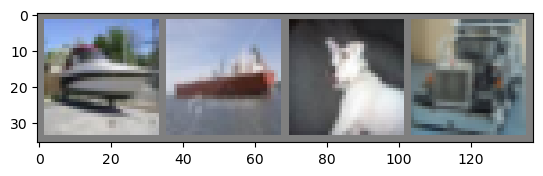

ship  ship  dog   truck


In [3]:
# # Function to show an image

# def imshow(img):
#     img = img / 2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()
    
    
# # Get some random training images
# dataiter = iter(trainloader)
# images, labels = next(dataiter)

# # Show images
# imshow(torchvision.utils.make_grid(images))
# # Print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.batchnorm4 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))
        x = self.pool(F.relu(self.batchnorm4(self.conv4(x))))
        x = x.view(-1, 256 * 2 * 2)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# instance of model
net = ImprovedCNN()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision

# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./cifar10_data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Define optimizer and loss function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

def train(net, trainloader, epochs=50):
    net.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if i % 100 == 99:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f} | acc: {100.*correct/total:.2f}%')
                running_loss = 0.0
                correct = 0
                total = 0

        # Validate and update learning rate
        val_loss = validate(net, testloader)
        scheduler.step(val_loss)

    print('Finished Training')

def validate(net, dataloader):
    net.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f'Validation Accuracy: {100.*correct/total:.2f}%')
    return val_loss / len(dataloader)

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
net = net.to(device)

# Train the network
train(net, trainloader)

# Test the network
net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

Files already downloaded and verified
Files already downloaded and verified
Using device: cpu
[1,   100] loss: 1.790 | acc: 32.93%
[1,   200] loss: 1.451 | acc: 46.71%
[1,   300] loss: 1.306 | acc: 52.90%
Validation Accuracy: 58.11%
[2,   100] loss: 1.471 | acc: 46.30%
[2,   200] loss: 1.122 | acc: 59.19%
[2,   300] loss: 1.055 | acc: 62.21%
Validation Accuracy: 65.63%
[3,   100] loss: 0.943 | acc: 66.54%
[3,   200] loss: 0.893 | acc: 67.58%
[3,   300] loss: 0.871 | acc: 68.87%
Validation Accuracy: 70.64%
[4,   100] loss: 0.817 | acc: 71.02%
[4,   200] loss: 0.796 | acc: 72.05%
[4,   300] loss: 0.796 | acc: 71.71%
Validation Accuracy: 74.09%
[5,   100] loss: 0.726 | acc: 74.26%
[5,   200] loss: 0.729 | acc: 74.59%
[5,   300] loss: 0.714 | acc: 75.11%
Validation Accuracy: 75.02%
[6,   100] loss: 0.688 | acc: 76.02%
[6,   200] loss: 0.666 | acc: 76.65%
[6,   300] loss: 0.674 | acc: 76.16%
Validation Accuracy: 77.09%
[7,   100] loss: 0.646 | acc: 77.79%
[7,   200] loss: 0.641 | acc: 77.23